In [11]:
import json
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from architectures import *
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from utils import *

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
SEED = 37
ROOT_PATH = os.getcwd()
os.makedirs(LOGS_PATH := os.path.join(ROOT_PATH, "logs"), exist_ok=True)
os.makedirs(RAW_DATASET_PATH := os.path.join(ROOT_PATH, "dataset", "raw"), exist_ok=True)
os.makedirs(PRODUCTION_DATASET_PATH := os.path.join(ROOT_PATH, "dataset", "production"), exist_ok=True)
os.makedirs(MODELS_PATH := os.path.join(ROOT_PATH, "models"), exist_ok=True)

SUBSAMPLE_SIZE = 10000
NOISE_RATIO = 0.5
EARTHQUAKE_RATIO = 0.5

BATCH_SIZE = 32
LEARNING_RATE = 0.001
NUM_EPOCHS = 50
PATIENCE = 7
FINETUNING = False

print(DEVICE)
seed_functions(SEED)

cuda


Preprocessing

In [ ]:
def preprocess_data():
	"""Computes, saves, and prints summary of preprocessed data."""

	# Compute preprocessed data
	data_processor = DataPreprocessing(
		subsample_size=SUBSAMPLE_SIZE,
		raw_dataset_path=RAW_DATASET_PATH,
		logs_path=LOGS_PATH,
		noise_ratio=NOISE_RATIO,
		earthquake_ratio=EARTHQUAKE_RATIO
	)

	# Save preprocessed data
	signals = data_processor.subsample_traces
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"signals_{SUBSAMPLE_SIZE}.npy"), np.array(list(signals.values())))
	metadata = data_processor.subsample_metadata
	metadata.to_feather(os.path.join(PRODUCTION_DATASET_PATH, f"metadata_{SUBSAMPLE_SIZE}.feather"))
	waveform_images = data_processor.create_waveform_images()
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"waveform_images_{SUBSAMPLE_SIZE}.npy"), waveform_images)
	spectrogram_images = data_processor.create_spectrogram_images()
	np.save(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"), spectrogram_images)

	# Print summary of preprocessed data
	print(f"""
	1. Expected samples: {SUBSAMPLE_SIZE}
	2. Actual samples: {len(signals)}\n{metadata['category'].value_counts(normalize=True)}
	""")

# preprocess_data()

def visualise_data(num_samples=1):
	"""Randomly selects and plots pair(s) of waveform and spectrogram images."""

	# Load saved images
	waveform_images = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"waveform_images_{SUBSAMPLE_SIZE}.npy"))
	spectrogram_images = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"))

	# Create figure with subplots
	fig, axes = plt.subplots(num_samples, 2, figsize=(6, 3 * num_samples))

	# Ensure axes is iterable for a single sample case
	if num_samples == 1: axes = [axes]

	# Plot random images
	for i1, i2 in enumerate(np.random.choice(len(waveform_images), num_samples, replace=False)):
		axes[i1][0].imshow(waveform_images[i2])
		axes[i1][0].set_title(f"Waveform {i2}")
		axes[i1][0].axis("off")
		axes[i1][1].imshow(spectrogram_images[i2])
		axes[i1][1].set_title(f"Spectrogram {i2}")
		axes[i1][1].axis("off")
	plt.tight_layout()
	plt.show()

# visualise_data()

Loading

In [12]:
model = CNN().to(DEVICE)

# Load production dataset and compute labels
spectrograms = np.load(os.path.join(PRODUCTION_DATASET_PATH, f"spectrogram_images_{SUBSAMPLE_SIZE}.npy"))
metadata = pd.read_feather(os.path.join(PRODUCTION_DATASET_PATH, f"metadata_{SUBSAMPLE_SIZE}.feather"))
labels = (metadata["category"] == "earthquake").astype(np.float32).values  # 0 (noise), 1 (earthquake)

# Normalize and convert spectrograms and labels to tensors
spectrograms = torch.tensor(spectrograms.astype(np.float32) / 255.0).permute(0, 3, 1, 2)
labels = torch.tensor(labels).view(-1, 1)

def split_data(spectrograms, labels, test_size=0.2, dev_size=0.5):
	train_i, temp_i, train_labels, temp_labels = train_test_split(spectrograms, labels, test_size=test_size, stratify=labels, random_state=SEED)
	dev_i, test_i, dev_labels, test_labels = train_test_split(temp_i, temp_labels, test_size=dev_size, stratify=temp_labels, random_state=SEED)
	return train_i, train_labels, dev_i, dev_labels, test_i, test_labels

# Split production dataset into train, dev, and test sets
train_i, train_labels, dev_i, dev_labels, test_i, test_labels = split_data(spectrograms, labels)

def load_data(model):
	train_generator = torch.Generator()
	train_generator.manual_seed(SEED)

	if getattr(model, "expects224", False):
		train_loader = DataLoader(SpectrogramDataset224(SpectrogramDataset(train_i, train_labels)), batch_size=BATCH_SIZE, shuffle=True, generator=train_generator)
		dev_loader = DataLoader(SpectrogramDataset224(SpectrogramDataset(dev_i, dev_labels)), batch_size=BATCH_SIZE, shuffle=False)
		test_loader = DataLoader(SpectrogramDataset224(SpectrogramDataset(test_i, test_labels)), batch_size=BATCH_SIZE, shuffle=False)
		return train_loader, dev_loader, test_loader

	train_loader = DataLoader(SpectrogramDataset(train_i, train_labels), batch_size=BATCH_SIZE, shuffle=True, generator=train_generator)
	dev_loader = DataLoader(SpectrogramDataset(dev_i, dev_labels), batch_size=BATCH_SIZE, shuffle=False)
	test_loader = DataLoader(SpectrogramDataset(test_i, test_labels), batch_size=BATCH_SIZE, shuffle=False)
	return train_loader, dev_loader, test_loader

train_loader, dev_loader, test_loader = load_data(model)

if FINETUNING:
	pretrained_weights = torch.load("./models/R50ViTB16/best.pth", map_location=DEVICE)
	model_dict = model.state_dict()
	compatible_weights = {k: v for k, v in pretrained_weights.items() if k in model_dict and v.shape == model_dict[k].shape}
	model_dict.update(compatible_weights)
	model.load_state_dict(model_dict)
	print(f"Loaded {len(compatible_weights)} of {len(model_dict)} parameters from pretrained model")

Training

In [13]:
"""
	Notes:
	(1) In train_model, one may also compute, display, and save metrics (e.g. F1) on the train or dev set. To save compute, we chose not to.
"""

def evaluate_model(model, dataloader):
	model.eval()
	Y_hat, Y = [], []
	with torch.no_grad():
		for x, y in dataloader:
			Y_hat.append(model(x.to(DEVICE)).round().cpu())
			Y.append(y)
	tn, fp, fn, tp = confusion_matrix(torch.cat(Y), torch.cat(Y_hat)).ravel()
	f1 = compute_f1(tp, tn, fp, fn)
	return {
		"tp": int(tp),
		"tn": int(tn),
		"fp": int(fp),
		"fn": int(fn),
		"f1": float(f1)
	}

def train_model(model, train_loader, dev_loader, criterion, optimizer):
	# Create model folder
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	os.makedirs(model_folder, exist_ok=True)

	best_dev_loss = float("inf")
	best_model_path = os.path.join(model_folder, "best.pth")
	patience_counter = 0
	train_losses = []
	dev_losses = []

	for epoch in range(NUM_EPOCHS):
		# Train model on train set
		model.train()
		total_loss = 0
		for images, labels in train_loader:
			images, labels = images.to(DEVICE), labels.to(DEVICE)
			optimizer.zero_grad()
			outputs = model(images)
			loss = criterion(outputs, labels)
			loss.backward()
			optimizer.step()
			total_loss += loss.item()
		train_loss = total_loss / len(train_loader)
		train_losses.append(train_loss)

		# Evaluate model on dev set
		model.eval()
		dev_loss = 0
		with torch.no_grad():
			for images, labels in dev_loader:
				images, labels = images.to(DEVICE), labels.to(DEVICE)
				outputs = model(images)
				dev_loss += criterion(outputs, labels).item()
		dev_loss /= len(dev_loader)
		dev_losses.append(dev_loss)

		print(f"Epoch: {epoch+1} of {NUM_EPOCHS} - Training loss: {train_loss:.4f} - Validation loss: {dev_loss:.4f}")

		# Save model epoch checkpoint
		torch.save(model.state_dict(), os.path.join(model_folder, f"epoch={epoch+1}-dev_loss={dev_loss:.4f}.pth"))
		if dev_loss < best_dev_loss:
			best_dev_loss = dev_loss
			torch.save(model.state_dict(), best_model_path)  # Save best model
			patience_counter = 0  # Reset patience counter
		else:
			patience_counter += 1
			# Stop early if needed
			if patience_counter >= PATIENCE:
				print("Stopping early")
				break

	# Save losses
	loss_data = {"train_losses": train_losses, "dev_losses": dev_losses}
	with open(os.path.join(model_folder, "losses.json"), "w") as f:
		json.dump(loss_data, f)

criterion = nn.BCELoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE)
train_model(model, train_loader, dev_loader, criterion, optimizer)

Epoch: 1 of 50 - Training loss: 0.2340 - Validation loss: 0.0707
Epoch: 2 of 50 - Training loss: 0.1045 - Validation loss: 0.0949
Epoch: 3 of 50 - Training loss: 0.0842 - Validation loss: 0.0479
Epoch: 4 of 50 - Training loss: 0.0634 - Validation loss: 0.0456
Epoch: 5 of 50 - Training loss: 0.0497 - Validation loss: 0.0348
Epoch: 6 of 50 - Training loss: 0.0428 - Validation loss: 0.0426
Epoch: 7 of 50 - Training loss: 0.0434 - Validation loss: 0.0402
Epoch: 8 of 50 - Training loss: 0.0332 - Validation loss: 0.0403
Epoch: 9 of 50 - Training loss: 0.0262 - Validation loss: 0.0373
Epoch: 10 of 50 - Training loss: 0.0264 - Validation loss: 0.0402
Epoch: 11 of 50 - Training loss: 0.0262 - Validation loss: 0.0333
Epoch: 12 of 50 - Training loss: 0.0229 - Validation loss: 0.0371
Epoch: 13 of 50 - Training loss: 0.0190 - Validation loss: 0.0420
Epoch: 14 of 50 - Training loss: 0.0197 - Validation loss: 0.0517
Epoch: 15 of 50 - Training loss: 0.0474 - Validation loss: 0.0373
Epoch: 16 of 50 - T

Post-training

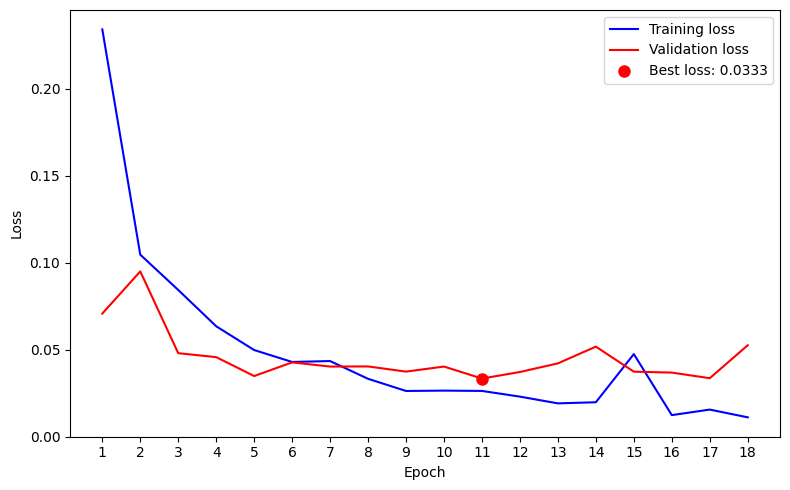

{'tp': 496, 'tn': 497, 'fp': 3, 'fn': 4, 'f1': 0.9929929929929929}


In [14]:
def visualise_training(model):
	# Load losses
	model_folder = os.path.join(MODELS_PATH, f"{model.id}")
	with open(os.path.join(model_folder, "losses.json"), "r") as f:
		loss_data = json.load(f)
	train_losses = loss_data["train_losses"]
	dev_losses = loss_data["dev_losses"]

	plt.figure(figsize=(8, 5))
	epochs = range(1, len(train_losses) + 1)
	plt.plot(epochs, train_losses, "b-", label="Training loss")
	plt.plot(epochs, dev_losses, "r-", label="Validation loss")

	# Annotate the best loss
	best_epoch = np.argmin(dev_losses) + 1
	best_loss = min(dev_losses)
	plt.plot(best_epoch, best_loss, "ro", markersize=8, label=f"Best loss: {best_loss:.4f}")

	plt.xlabel("Epoch")
	plt.ylabel("Loss")
	plt.legend()
	plt.gca().xaxis.set_major_locator(ticker.MultipleLocator(1))
	plt.tight_layout()
	plt.show()

m = model.__class__().to(DEVICE)
visualise_training(m)

def load_weights(model):
	state_dict = torch.load(os.path.join(MODELS_PATH, model.id, "best.pth"), weights_only=False)
	state_dict.pop('_metadata', None)
	model.load_state_dict(state_dict)

load_weights(m)
print(evaluate_model(m, test_loader))